# The following code produces Figure 3, S7 and S8 from Nicholson et al. 2021 "Storms drive CO2 outgassing in the Subpolar Southern Ocean"

Author: Sarah Nicholson
Contact: snicholson@csir.co.za
Last modified: 10 November 2021

In [1]:
%pylab inline
import glidertools as gt
import xarray as xr
import pandas as pd
import seawater as sw
import cmocean as cmo
import seaborn as sns
import PyCO2SYS as pyco2
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy import integrate
from sklearn.linear_model import LinearRegression
import gsw

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['savefig.dpi'] = 150
rcParams['figure.figsize'] = [6, 3]
rcParams['figure.dpi'] = 150
sns.set_style("white")
rcParams['font.size'] = 12
rcParams['font.family'] = 'Arial'
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator(interval=1)
days = mdates.DayLocator(interval=1)
hrs = mdates.HourLocator(interval=1)
daysFmt = mdates.DateFormatter("%h")
yearsFmt = mdates.DateFormatter("%d\%m")

# WAVEGLIDER CO2

In [3]:
WG = pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/WG_and_timeseries_nicholson_etal_2021.csv')
i = (WG.Date < '2018-12-21')
WG_GDAP = WG[i]
WG = WG.copy()

# Load in JRA winds 

In [4]:

j = pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/JRA_collocated_glider.csv')

# DOWNLOAD DIC, TA and PCO2:

## Broullon climatology of dic, ta and pco2

Broullón, D. et al. A global monthly climatology of total alkalinity: a neural network approach. Earth Syst. Sci. Data 11, 1109–1127 (2019).
https://digital.csic.es/handle/10261/194411

Broullón, D. et al. A global monthly climatology of oceanic total dissolved inorganic carbon: a neural network approach. Earth Syst. Sci. Data 12, 1725–1743 (2020).
https://digital.csic.es/handle/10261/200537

In [5]:
# User needs to download this data set.
fpath = '/ADDYOURPATH/'

ta_b1 = xr.open_dataset(fpath+'TCO2_NNGv2LDEO_climatology.nc')
depth_b = ta_b1.depth
tco2_b1 = xr.open_dataset(fpath+ 'TCO2_NNGv2LDEO_climatology.nc')
talk_b1 = xr.open_dataset(fpath+ 'AT_NNGv2_climatology.nc')

In [7]:
# collocated glider location from above dataset
pco2_grad_b = xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/pCO2grad_Broullon_WG.nc')
ta_b =xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/TALK_Broullon_WG.nc')
dic_b =xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/DIC_Broullon_WG.nc')
dic_b_wg = dic_b.TCO2_NNGv2LDEO[:,6].values
ta_b_wg = ta_b.AT_NNGv2[:,6].values

## GLODAP v2020 data DIC, pCO2 and TA for individual cruises

data download: https://www.ncei.noaa.gov/access/ocean-carbon-data-system/oceans/GLODAPv2_2020/

In [8]:
# This dataset has been made available but please see link above for original source.

# surface layer upper 100m 
fpath = '../Data/'
fname = 'GLODAPv2.2020_Merged_Master_File.csv'
glor = pd.read_csv(fpath+fname)
i =  (glor.talk > 0)  & (glor.tco2 > 100) &(glor.depth <= 100) & (glor.latitude <= -51.5)& (glor.latitude >= -56.5) & (glor.longitude > - .5)& (glor.longitude < .5) #& (glor.year > 2007)
gdap19_wg = glor[i].copy()
gdap19_wg.phosphate[gdap19_wg.phosphate<-9990] = np.nan
gdap19_wg.silicate[gdap19_wg.silicate<-9990] = np.nan
gdap19_wg.salinity[gdap19_wg.salinity<-9990] = np.nan
gdap19_wg.temperature[gdap19_wg.temperature<-9990] = np.nan

In [9]:
# DEPTH >100m
i =  (glor.talk > 0)  & (glor.tco2 > 100) &(glor.depth <= 400) & (glor.latitude <= -51.5)& (glor.latitude >= -56.5) & (glor.longitude > - .5)& (glor.longitude < .5) #& (glor.year > 2007)
gdap19_wgz = glor[i].copy()
gdap19_wgz.phosphate[gdap19_wgz.phosphate<-9990] = np.nan
gdap19_wgz.silicate[gdap19_wgz.silicate<-9990] = np.nan
gdap19_wgz.salinity[gdap19_wgz.salinity<-9990] = np.nan
gdap19_wgz.temperature[gdap19_wgz.temperature<-9990] = np.nan

# Ekman Advection

## Inertial period:

In [10]:

def coriolis(lat):  
    omega   = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    return 2*omega*np.sin(lat/360.*2*np.pi)

f = coriolis(-54) # seconds
T = int(np.round((2*pi/np.abs(f)/3600)))
# T/4 and T/2 used for smoothing later
T4 =  int(np.round((2*pi/np.abs(f)/3600))/4)
T2 =  int(np.round((2*pi/np.abs(f)/3600))/2)

## Using WG wind data

In [11]:
tau_u = WG.Wind_stress_nm2.bfill()*cos(np.deg2rad(WG.Wind_dir_deg.bfill()))
tau_v = WG.Wind_stress_nm2.bfill()*sin(np.deg2rad(WG.Wind_dir_deg.bfill()))
f = np.nanmean(coriolis(-54))
ue = tau_v / (WG.Density.bfill().ffill().mean() *WG.xld_slocum_m.bfill().ffill() * f)
ve =  - (tau_u / (WG.Density.bfill().ffill().mean()  * WG.xld_slocum_m.bfill().ffill() * f))
ek = ve + ue

# integrate ekman velocity over daily periods to get displacement in meters:
X = np.insert(integrate.cumtrapz(ue,dx=86400),0,np.nan)
Y = np.insert(integrate.cumtrapz(ve,dx=86400),0,np.nan)
data = {'Date':pd.to_datetime(WG.Date.values),'Vek':ve,'Vek_int':Y,'Uek':ue,'Uek_int':X}
ekv = pd.DataFrame(data)
ekv = ekv.set_index('Date')

# displacment anomalies by removing 10day mean:
ekv['Vek_anom'] = ekv.Vek_int-ekv.Vek_int.rolling(24*10,center=True,min_periods=2).mean()

## Using JRA wind data

In [12]:
# JRA WINDS AND XLD
import airsea as air
# Pond and large et al.,
z0 = 1.52e-4 # roughness length
zm = 1 # WG measures wind 1m from surface 
z10 = 10 # 

# Wind stress  
JRA_Wind_stress = air.windstress.stress(j.wind_speed_JRA_ms,z=10.0, drag='largepond', rho_air=1.22, Ta=j.surface_air_temperature_JRA_degC)
tau_u = JRA_Wind_stress*cos(np.deg2rad(j.wind_direction_JRA_deg))
tau_v = JRA_Wind_stress*sin(np.deg2rad(j.wind_direction_JRA_deg))

# Mixing layer depth / here i test ustar, slope is from Fig S5 :
slope_ustar  = 4114.4451791796455 
xld_wg  = j.friction_velocity_JRA_ms*slope_ustar 

#u = tau/(rho H f):
f = np.nanmean(coriolis(-54))
ue = tau_v / (1027 *xld_wg * f) 
ve =  - (tau_u / (1027  * xld_wg * f)) 

# integrate to velocity to meters:
X = np.insert(integrate.cumtrapz(ue,dx=86400*3),0,np.nan)
Y = np.insert(integrate.cumtrapz(ve,dx=86400*3),0,np.nan)
data = {'Date':pd.to_datetime(j.Date),'Vek':ve,'Vek_int':Y,'Uek':ue,'Uek_int':X}
ekv1 = pd.DataFrame(data)
ekv1 = ekv1.set_index('Date')
ekv1['Vek_anom_jra'] = ekv1.Vek_int-ekv1.Vek_int.rolling(10*8,center=True,min_periods=2).mean()#.bfill().ffill()
vek_anom_jra_t  = interp((pd.to_datetime(WG.Date)),ekv1.index,ekv1['Vek_anom_jra'])

# Supplementary figure S7:

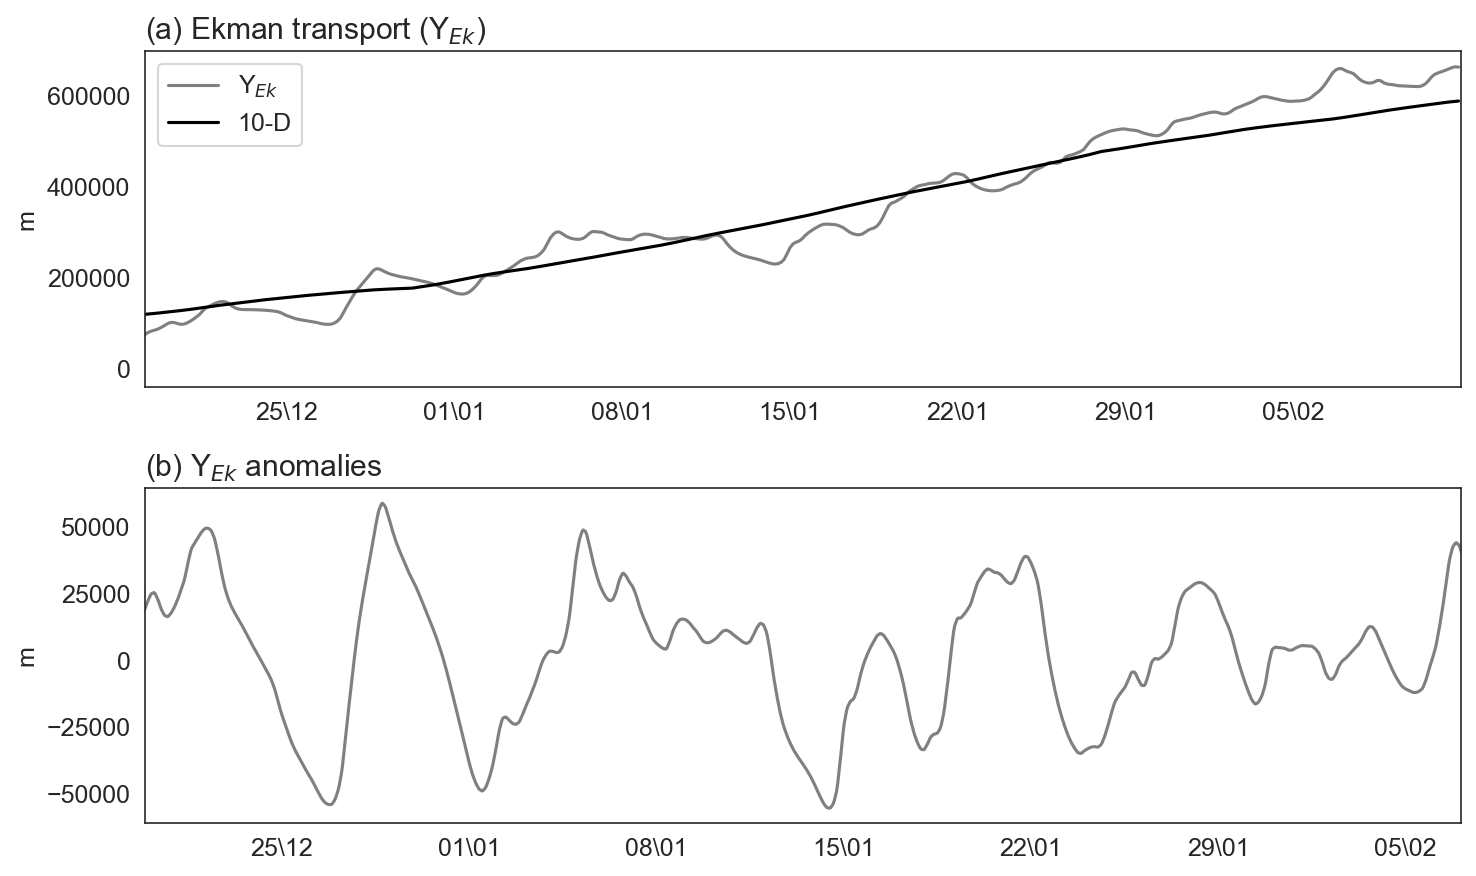

In [13]:
plt.figure(figsize = (10,6))
ax = plt.subplot(211)

plt.plot(pd.to_datetime(ekv1.index.values),ekv1['Vek_int'],color='grey',label='Y$_{Ek}$')
plt.title('(a) Ekman transport (Y$_{Ek}$)',loc='left')
plt.ylabel('m')
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_major_locator(weeks)
plt.plot(pd.to_datetime(ekv1.index.values),ekv1.Vek_int.rolling(24*10,center=True,min_periods=2).mean(),color='k',label='10-D')
plt.xlim(pd.to_datetime(WG.Date[1]),pd.to_datetime(WG.Date.values[-1]))
plt.legend()

ax = plt.subplot(212)
plt.plot(pd.to_datetime(WG.Date.values),vek_anom_jra_t,color='grey')
plt.title('(b) Y$_{Ek}$ anomalies',loc='left')
plt.ylabel('m')
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_major_locator(weeks)
plt.xlim(pd.to_datetime(WG.Date[20]),pd.to_datetime(WG.Date[1200]))
plt.tight_layout()


# COMPUTE LATERAL GRADIENTS DIC and TA 

## Individual yearly cruises that past over glider location

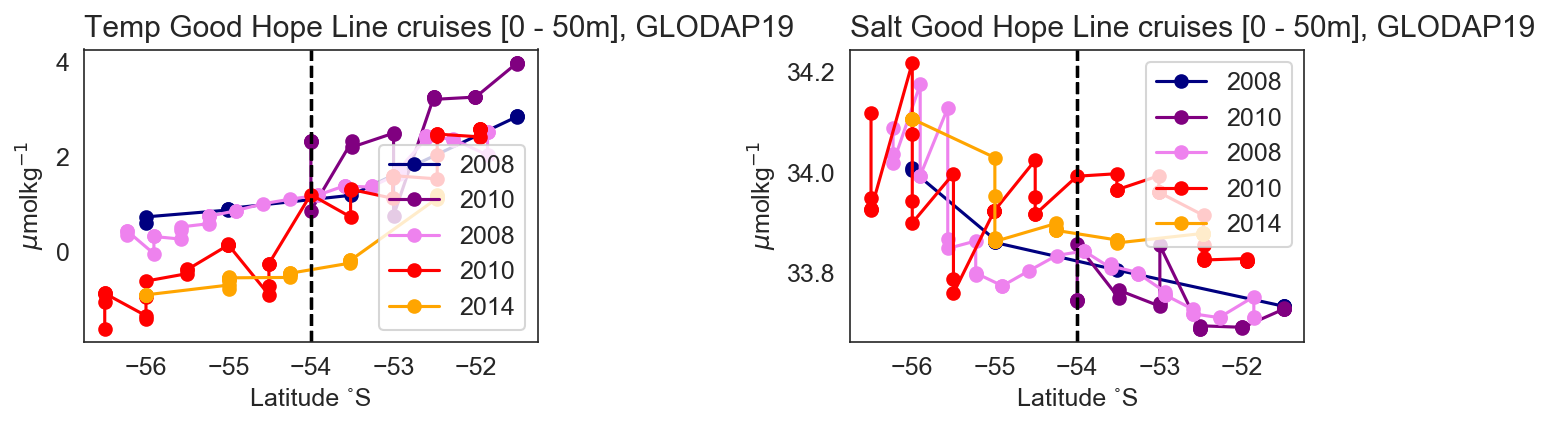

In [14]:
plt.figure(figsize=(10,3))
cruises= [19,346,385,20,1004]
plt.subplot(1,2,1)
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
for i in range(np.size(cruises)):
    plt.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude, gdap19_wg[gdap19_wg.cruise == cruises[i]].temperature,marker='o',label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color=colors[i])
    plt.title('Temp Good Hope Line cruises [0 - 50m], GLODAP19',loc='left')
    plt.axvline(-54,color='k',ls='--')
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
plt.legend()

plt.subplot(1,2,2)
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
for i in range(np.size(cruises)):
    plt.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude, gdap19_wg[gdap19_wg.cruise == cruises[i]].salinity,marker='o',label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color=colors[i])
    plt.title('Salt Good Hope Line cruises [0 - 50m], GLODAP19',loc='left')
    plt.axvline(-54,color='k',ls='--')
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
plt.legend()

plt.tight_layout()

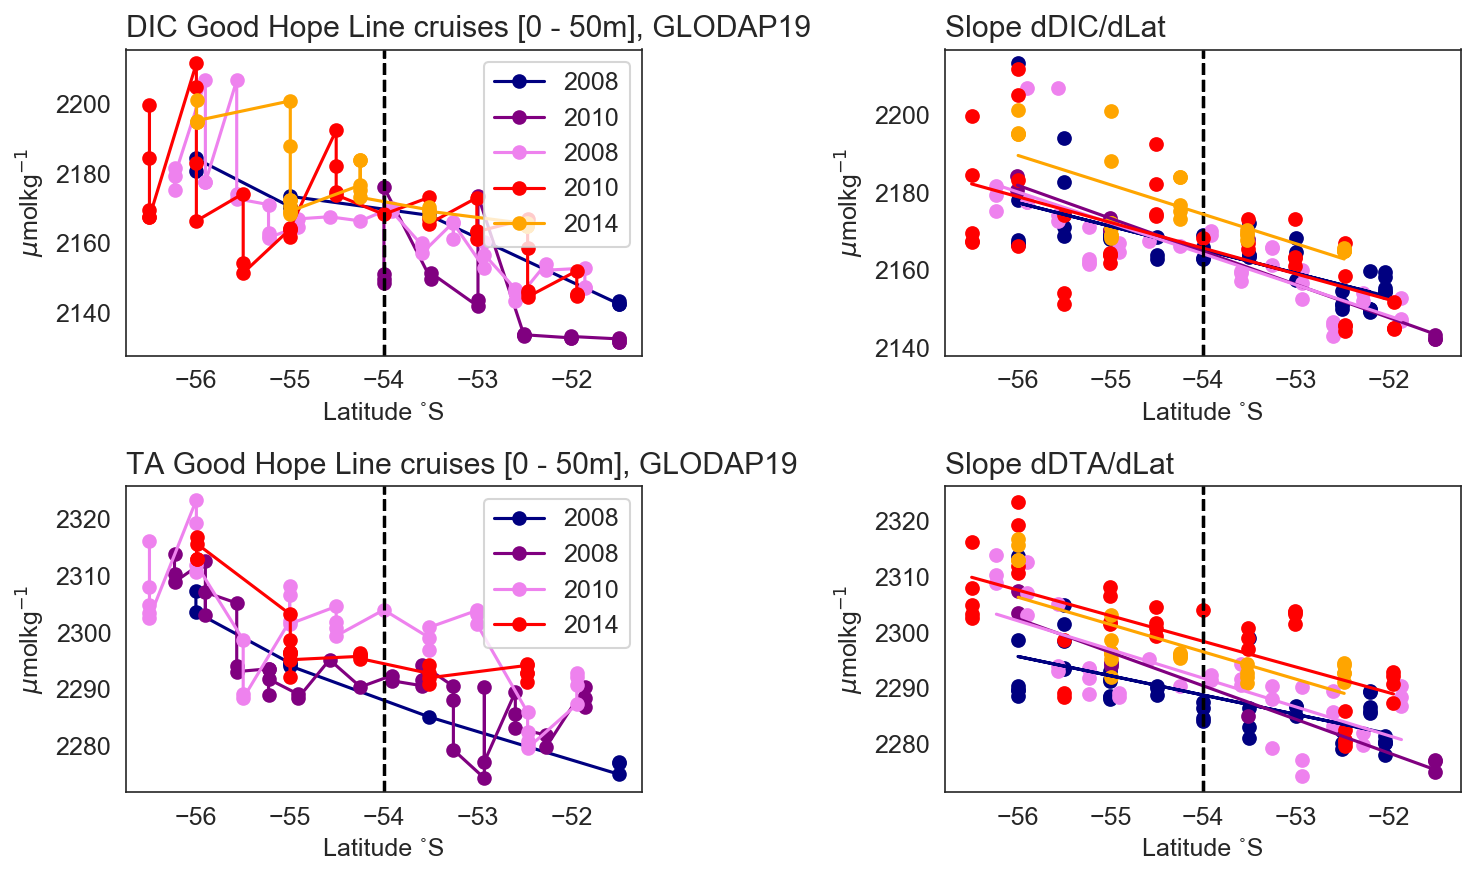

In [15]:
ic =  (gdap19_wg.cruise == 6) | (gdap19_wg.cruise == 13) | (gdap19_wg.cruise == 14) | (gdap19_wg.cruise == 18) | (gdap19_wg.cruise == 19) | (gdap19_wg.cruise == 385)|(gdap19_wg.cruise == 20)| (gdap19_wg.cruise == 1004)
figure(figsize=(10,6))
plt.subplot(2,2,1)
cruises= [19,346,385,20,1004]
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
for i in range(np.size(cruises)):
    plt.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude, gdap19_wg[gdap19_wg.cruise == cruises[i]].tco2,marker='o',label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color=colors[i])
    plt.title('DIC Good Hope Line cruises [0 - 50m], GLODAP19',loc='left')
    plt.axvline(-54,color='k',ls='--')
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
plt.legend()

plt.subplot(2,2,2)

cruises= [18,19,385,20,1004]
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
slopes = np.zeros((np.size(cruises)))
for i in range(np.size(cruises)):
#i=4
    gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude
    x = gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude.values
    y = gdap19_wg[gdap19_wg.cruise == cruises[i]].tco2.values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    y1 = slope*x + intercept
    plt.scatter(x,y,s=50,alpha=1,lw=0,color=colors[i])
    plt.axvline(-54,color='k',ls='--')
    plt.plot(x,y1 ,color=colors[i])
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
    slopes[i]=slope
    plt.title('Slope dDIC/dLat',loc='left')
plt.tight_layout()



distlats = gsw.distance([-55,-54],[0.00,0.00])
slopes_m_dic=-1*(slopes/distlats)

plt.subplot(2,2,3)
cruises= [19,385,20,1004]
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
for i in range(np.size(cruises)):
    TALK = gdap19_wg[gdap19_wg.cruise == cruises[i]].talk.values; TALK[TALK < 0] = np.nan
    plt.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude,TALK,marker='o',label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color=colors[i])
    plt.title('TA Good Hope Line cruises [0 - 50m], GLODAP19',loc='left')
    plt.axvline(-54,color='k',ls='--')
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
plt.legend()

plt.subplot(2,2,4)

cruises= [18,19,385,20,1004]
colors=['navy','purple','violet','red','orange','brown','olive','green','darkgreen','black']
slopes = np.zeros((np.size(cruises)))
for i in range(np.size(cruises)):
#i=4
    gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude
    x = gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude.values
    y = gdap19_wg[gdap19_wg.cruise == cruises[i]].talk.values; 
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    y1 = slope*x + intercept
    plt.scatter(x,y,s=50,alpha=1,lw=0,color=colors[i])
    plt.axvline(-54,color='k',ls='--')
    plt.plot(x,y1 ,color=colors[i])
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
    slopes[i]=slope
    plt.title('Slope dDTA/dLat',loc='left')
plt.tight_layout()

distlats = gsw.distance([-55,-54],[0.00,0.00])
slopes_m_ta=-1*(slopes/distlats)


## pCO2 gradient, estimated from DIC and TA



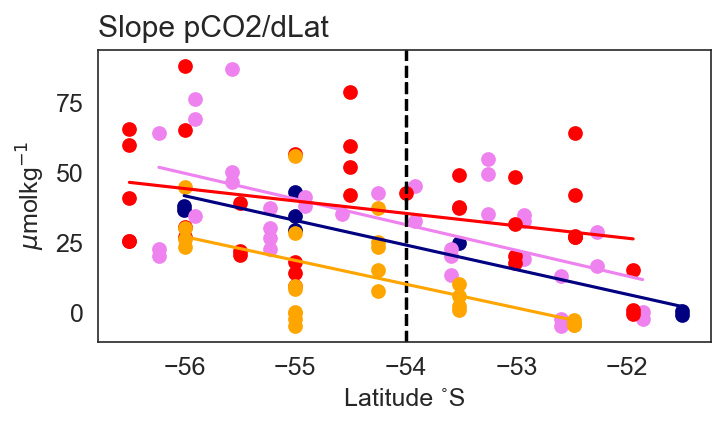

In [16]:
pHscale  =    1 # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c    =    4 # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c    =    1 # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

figure(figsize=(5,3))

cruises=  [19,385,20,1004]
colors=['navy','violet','red','orange','brown','olive','green','darkgreen','black']
slopes = np.zeros((np.size(cruises)))

# calculate pCO2 for each cruise:
for i in range(np.size(cruises)):
    lats = gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude.values
    tco2 = gdap19_wg[gdap19_wg.cruise == cruises[i]].tco2.values; 
    talk = gdap19_wg[gdap19_wg.cruise == cruises[i]].talk.values;
    salt = gdap19_wg[gdap19_wg.cruise == cruises[i]].salinity.values;
    temp = gdap19_wg[gdap19_wg.cruise == cruises[i]].temperature.values; 

    #DICT = CO2SYS(talk, tco2,1, 2, salt, temp, temp, 0, 0, 43, 1.8,pHscale, k1k2c, kso4c)[0]
    kwargs = dict(
        par1 = talk,  # Value of the first parameter
        par2 = tco2,  # Value of the second parameter, which is a long vector of different DIC's!
        par1_type = 1,  # The first parameter supplied is of type "1", which is "alkalinity"
        par2_type = 2,  # The second parameter supplied is of type "2", which is "DIC"
        salinity = salt,  # Salinity of the sample
        temperature = temp,  # Temperature at input conditions
        pressure = 0,
        pressure_out=0,
        total_silicate = 43,  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = 1.8,  # Concentration of phosphate in the sample (in umol/kg)
        opt_pH_scale=pHscale,
        opt_k_carbonic = k1k2c,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
        opt_k_bisulfate = kso4c,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
        )
    DICT=pyco2.sys(**kwargs)
    pco2=DICT['pCO2']
    # calculate the change in pco2 due to temperature and remove effect:
    #--------------------------------------------------------------------
    dpCO2_sst = np.zeros((np.size(pco2)))
    dpCO2 = np.zeros((np.size(pco2)))
    for ii in range(np.size(pco2)-1):
        dpCO2_sst[ii+1] = pco2[ii]*0.0423*(temp[ii+1] - temp[ii])
        dpCO2[ii+1] =  pco2[ii+1] - pco2[ii]
    # NON THERMAL COMPONENT OF dPCO2:
    dpCO2_dic = dpCO2 - dpCO2_sst 
    pCO2_sst =  integrate.cumtrapz(dpCO2_sst[:])                              
    pCO2_dic =  integrate.cumtrapz(dpCO2_dic[:])                              
 
    x = lats[1::]
    y =  pCO2_dic 
 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    y1 = slope*x + intercept
    plt.scatter(x,y,s=50,alpha=1,lw=0,color=colors[i])
    plt.axvline(-54,color='k',ls='--')
    plt.plot(x,y1,color=colors[i])
    plt.xlabel('Latitude ˚S')
    plt.ylabel('$\mu$molkg$^{-1}$')
    slopes[i]=slope
    plt.title('Slope pCO2/dLat',loc='left')
    #plt.xlim(-55,-5)
plt.tight_layout()

slopes_m_pco2=-1*(slopes/distlats)



## Broullon climatology pco2 gradient

In [17]:
broulgrads = pco2_grad_b.isel(time=[11,0,1]).__xarray_dataarray_variable__[:,6].values

## Add Glodap gradients with Broullon product gradient

In [18]:
surfbr = depth_b < 100
x=ta_b.lat[4:8].values
y=np.nanmean(ta_b.AT_NNGv2[surfbr,4:8],0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
distlats = gsw.distance([-56,-53],[0.00,0.00])
slopes_ta_br=-1*(slope/distlats)
slopes_ta_br
x=dic_b.lat[4:8].values
y=np.nanmean(dic_b.TCO2_NNGv2LDEO[surfbr,4:8],0)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
distlats = gsw.distance([-56,-53],[0.00,0.00])
slopes_dic_br=-1*(slope/distlats)
slopes_dic_br

array([2.58038233e-05])

In [19]:
grads_all = np.concatenate([broulgrads,slopes_m_pco2])
np.nanmean(grads_all)
np.nanmean(slopes_m_pco2)

slopes_m_dic1 = np.concatenate((slopes_m_dic,slopes_dic_br))
np.round(np.nanmean(slopes_m_dic1),5)

slopes_m_ta1 = np.concatenate((slopes_m_ta,slopes_ta_br))
np.round(np.nanmean(slopes_m_ta1),5)

4e-05

# Surface and subsurface reservoirs for all cruises

In [20]:

cruises= [18,385,20,1004]

dic_0=np.zeros((np.size(cruises)))
talk_0=np.zeros((np.size(cruises)))
salt_0=np.zeros((np.size(cruises)))
temp_0=np.zeros((np.size(cruises)))

dic_1=np.zeros((np.size(cruises)))
talk_1=np.zeros((np.size(cruises)))
salt_1=np.zeros((np.size(cruises)))
temp_1=np.zeros((np.size(cruises)))

subsurf_grad_dic = np.zeros((np.size(cruises)))
subsurf_grad_talk = np.zeros((np.size(cruises)))
subsurf_grad_temp = np.zeros((np.size(cruises)))
subsurf_grad_salt = np.zeros((np.size(cruises)))                          

for i in range(np.size(cruises)):
    depth = gdap19_wgz[gdap19_wgz.cruise == cruises[i]].depth#.values
    tco2 = gdap19_wgz[gdap19_wgz.cruise == cruises[i]].tco2#.values; 
    talk = gdap19_wgz[gdap19_wgz.cruise == cruises[i]].talk#.values;
    salt = gdap19_wgz[gdap19_wgz.cruise == cruises[i]].salinity#.values;
    temp = gdap19_wgz[gdap19_wgz.cruise == cruises[i]].temperature#.values; 

    # surface reservoir values: 
    #-------------------------------------
    surf = depth < WG.mld003_slocum_m.mean()
    dic_0[i] = np.nanmean(tco2[surf])
    talk_0[i] = np.nanmean(talk[surf])
    salt_0[i] = np.nanmean(salt[surf])
    temp_0[i] = np.nanmean(temp[surf])
    
    surfbr = depth_b <WG.mld003_slocum_m.mean()
    dic_0_br = np.nanmean(dic_b_wg[surfbr])
    talk_0_br = np.nanmean(ta_b_wg[surfbr])
    
    
     # surface reservoir values: 
    subsurfbr = (depth_b < WG.xld_slocum_m.max()) & (depth_b > WG.mld003_slocum_m.mean())
    dic_1_br = np.nanmean(dic_b_wg[subsurfbr])
    talk_1_br = np.nanmean(ta_b_wg[subsurfbr])
    subsurf = (depth < WG.xld_slocum_m.max()) & (depth > WG.mld003_slocum_m.mean())
    talk_1[i] = np.nanmean(talk[subsurf])
    dic_1[i] = np.nanmean(tco2[subsurf])
    temp_1[i] = np.nanmean(temp[subsurf])
    salt_1[i] = np.nanmean(salt[subsurf])


## Conceptual map of DIC VS TA

In [24]:
# parameter types
pHscale  =    1 # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c    =    4 # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c    =    1 # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
WG_talk = np.arange(WG.Total_Alkalinity_mumolkg[112:-45].rolling(24*10,center=True).mean().min(), WG.Total_Alkalinity_mumolkg[112:-130].rolling(24*10,center=True).mean().max(),.5)
WG_dic1 = np.arange(WG.Dissolved_Inorganic_Carbon_mumolkg[112:-45].rolling(24*10,center=True).mean().min()-2, WG.Dissolved_Inorganic_Carbon_mumolkg[112:-45].rolling(24*10,center=True).mean().max()+2,.5)
WG_talk1 = np.arange(WG.Total_Alkalinity_mumolkg[112:-45].rolling(24*10,center=True).mean().min()-2, WG.Total_Alkalinity_mumolkg[112:-45].rolling(24*10,center=True).mean().max()+3,.5)
WG_dic = np.arange(WG.Dissolved_Inorganic_Carbon_mumolkg[112:-45].rolling(24*10,center=True).mean().min(), WG.Dissolved_Inorganic_Carbon_mumolkg[112:-45].rolling(24*10,center=True).mean().max(),.5)
WG_sst = np.arange(WG.Temperature_degC[112:-45].rolling(24*10,center=True).mean().min(), WG.Temperature_degC[112:-45].rolling(24*10,center=True).mean().max(),.5)

pCO2_both_WG = np.zeros((size(WG_talk1),size(WG_dic1)))

k=0
i=0
for i in range(size(WG_talk1)):
   
    for j in range(size(WG_dic1)):
        kwargs = dict(
                    par1 = WG_talk1[i],  # Value of the first parameter
                    par2 = WG_dic1[j],  # Value of the second parameter, which is a long vector of different DIC's!
                    par1_type = 1,  # The first parameter supplied is of type "1", which is "alkalinity"
                    par2_type = 2,  # The second parameter supplied is of type "2", which is "DIC"
                    salinity = np.nanmean(WG.Abs_salinity_daily_WG_gkg[112:-130].values),  # Salinity of the sample
                    temperature = np.nanmean(WG.Temperature_degC[112:-45][112:-45].values),  # Temperature at input conditions
                    pressure = 0,
                    pressure_out=0,
                    total_silicate = 43,  # Concentration of silicate  in the sample (in umol/kg)
                    total_phosphate = 1.7,  # Concentration of phosphate in the sample (in umol/kg)
                    opt_pH_scale=pHscale,
                    opt_k_carbonic = k1k2c,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
                    opt_k_bisulfate = kso4c,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
                    )
        DICT=pyco2.sys(**kwargs)
        pco2 = DICT['pCO2']

        pCO2_both_WG[i,j] = pco2
    

# Entrainment  

In [25]:
dDIC = 0
dSalt = 0
dTemp = 0
dSi=0
dPO4=0
dAlk=0

# mixing layer:
H = WG.xld_slocum_m.rolling(T4,center=True,min_periods=2).mean().bfill().ffill().values

# MLD 
h1 = WG.mld003_slocum_m.rolling(T*4,center=True,min_periods=2).mean().bfill().ffill().max()

# SOLVING FOR:
pCO2_ent = np.zeros((size(H),4))
DIC_ent = np.zeros((size(H),4))
ALK_ent = np.zeros((size(H),4))

#----------------------------------------------------------------------------------#
#  Simulate carbon chemistry changes during 
#   entrainment events when the XLD > MLD
#----------------------------------------------------------------------------------#

dt=1

# inital properties set by WG
talk1_0 = np.nanmean(WG_talk)
dic1_0 = np.nanmean(WG_dic)
temp1_0 =np.nanmean(WG.Temperature_degC)
salt1_0 =np.nanmean(WG.Abs_salinity_daily_WG_gkg)

for i in np.arange(2,size(H)-1,1):
    
    # SURFACE RESERVOIR:
    #------------------
    kwargs = dict(
                    par1 = talk1_0+dAlk,  # Value of the first parameter
                    par2 = dic1_0+dDIC,  # Value of the second parameter, which is a long vector of different DIC's!
                    par1_type = 1,  # The first parameter supplied is of type "1", which is "alkalinity"
                    par2_type = 2,  # The second parameter supplied is of type "2", which is "DIC"
                    salinity = np.nanmean(salt1_0),  # Salinity of the sample
                    temperature = np.nanmean(temp1_0 ),  # Temperature at input conditions
                    pressure = 0,
                    pressure_out=0,
                    total_silicate = 43,  # Concentration of silicate  in the sample (in umol/kg)
                    total_phosphate = 1.8,  # Concentration of phosphate in the sample (in umol/kg)
                    opt_pH_scale=pHscale,
                    opt_k_carbonic = k1k2c,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
                    opt_k_bisulfate = kso4c,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
                    )
    DICT=pyco2.sys(**kwargs)
    pco2 = DICT['pCO2']

    pCO2_ent[i,:] = DICT['pCO2']
    DIC_ent[i,:] = dic1_0 + dDIC
    ALK_ent[i,:] = talk1_0 + dAlk

    # ENTRAINMENT EVENT ? 
    #------------------
    if (H[i]-h1 > 0) & ((H[i] - H[i-1]) > 0):
        dDIC  = 1/h1*(dic_1 - dic_0) * (H[i] - H[i-1]) / dt 
        dAlk  = 1/h1*(talk_1 - talk_0) * (H[i] - H[i-1]) / dt
        dTemp  = 0 
        dSalt  = 0 

    #---- NO ENTRAINMENT:----
    else:  
        dDIC = 0
        dSalt = 0
        dTemp = 0
        dSi=0
        dPO4=0
        dAlk=0

        
pCO2_ent[pCO2_ent<300]=np.nan
DIC_ent[DIC_ent<2000]=np.nan
ALK_ent[ALK_ent<2000]=np.nan

# Anomalies
pCO2_anom_ent = pCO2_ent-np.nanmin(pCO2_ent)
ALK_anom_ent = ALK_ent-np.nanmin(ALK_ent)
DIC_anom_ent = DIC_ent-np.nanmin(DIC_ent)

In [26]:
dic_ent_m = np.nanmean(DIC_ent,1)
ta_ent_m = np.nanmean(ALK_ent,1) 
pco2_ent_m = np.nanmean(pCO2_ent,1)

# SUPPLMENTARY FIGURE S8

In [27]:
ekv['ent_wg_mean_pco2mean']  = np.nanmean(pCO2_ent,1)
total_mean_pco2_mean = ekv.ent_wg_mean_pco2mean.rolling(T,center=True,min_periods=2).mean() + vek_anom_jra_t *np.nanmean(grads_all) #ves*np.nanmax(grads_all)

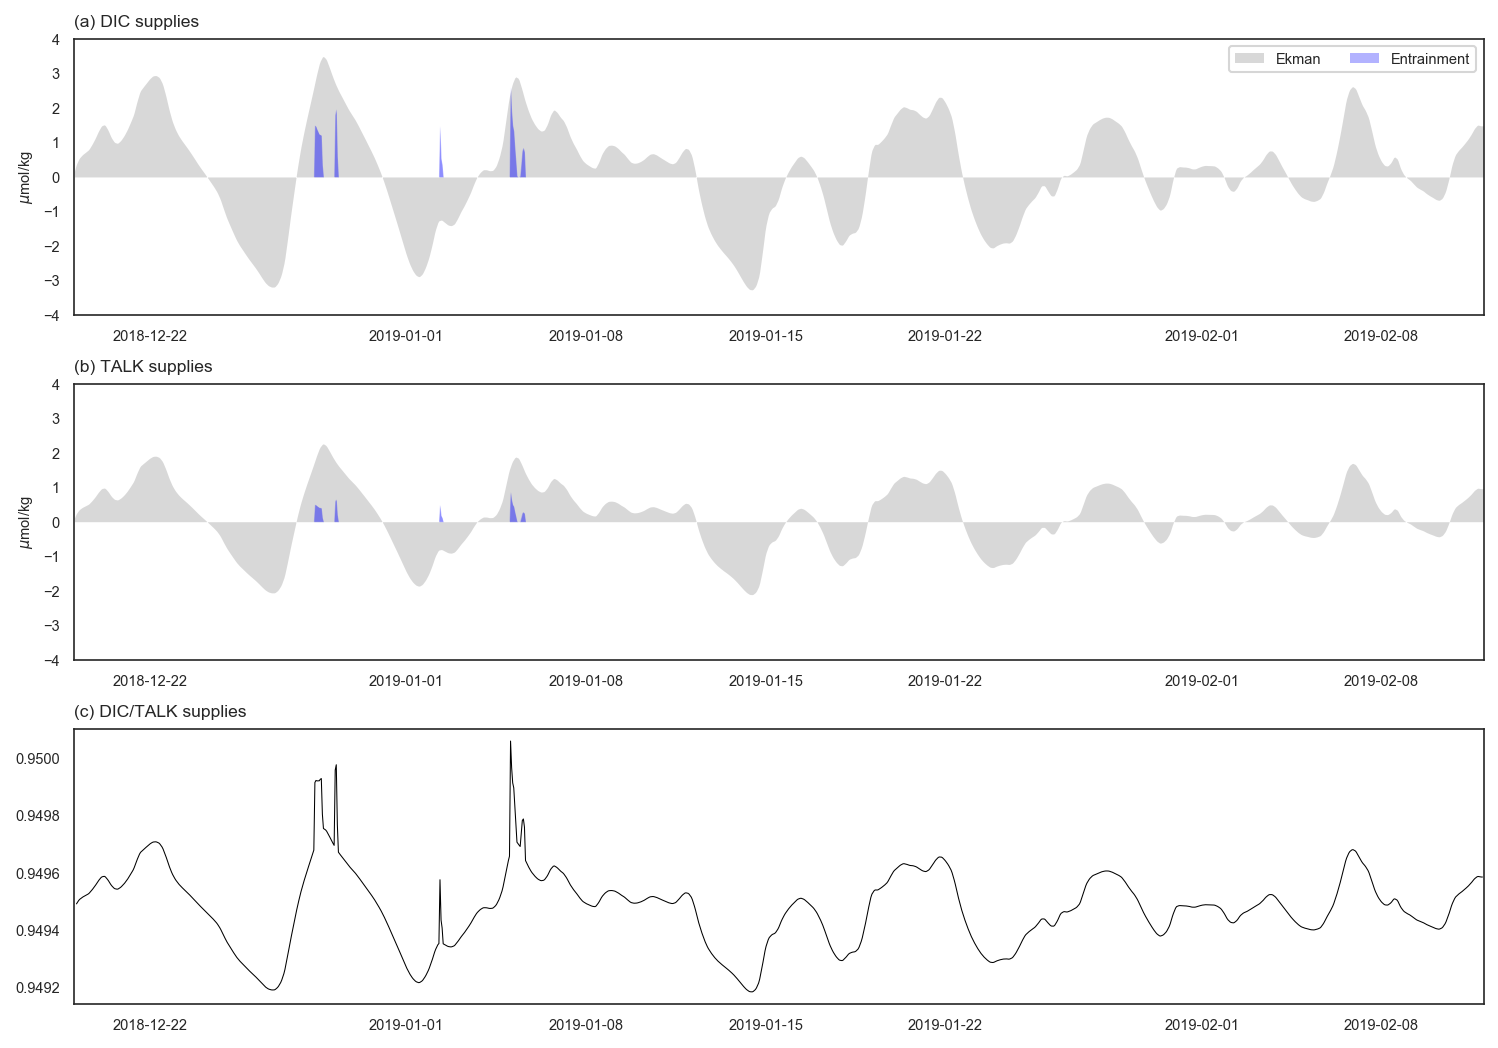

In [31]:
# =========== ESTIMATED PCO2 =====================================
#
plt.figure(figsize=(10,7))
plt.subplot(311)
X = pd.to_datetime(WG.Date.values)
Y1 = np.nanmean(WG_dic)+vek_anom_jra_t * np.nanmean(slopes_m_dic1)
Y2 = dic_ent_m 
plt.fill_between(X,Y1-np.nanmean(WG_dic),0,lw=0,color='grey',alpha=0.3,label='Ekman')
plt.fill_between(X,Y2-np.nanmean(WG_dic),0,lw=0,color='blue',alpha=0.3,label='Entrainment')
plt.fill_between(X,Y2-np.nanmean(WG_dic),0,lw=.5,edgecolors='None',facecolor='blue',alpha=0.2)
plt.ylim(-4,4)
plt.legend(ncol=3)
plt.title('(a) DIC supplies',loc='left')
plt.xlim(X.values[0],X.values[-1])
plt.ylabel('$\mu$mol/kg')

plt.subplot(312)
Y11 = np.nanmean(WG_talk)+vek_anom_jra_t*np.nanmean(slopes_m_ta1)
Y22 = ta_ent_m
plt.fill_between(X,Y11-np.nanmean(WG_talk),0,lw=0,color='grey',alpha=0.3,label='Ekman')
plt.fill_between(X,Y22-np.nanmean(WG_talk),0,lw=0,color='blue',alpha=0.3,label='Entrainment')
plt.fill_between(X,Y22-np.nanmean(WG_talk),0,lw=.5,edgecolors='None',facecolor='blue',alpha=0.2)
plt.ylim(-4,4)
plt.title('(b) TALK supplies',loc='left')
plt.xlim(X.values[0],X.values[-1])
plt.tight_layout()
plt.ylabel('$\mu$mol/kg')


plt.subplot(313)
rat = (Y1+Y2)/(Y11+Y22)
plt.plot(X,rat,'k',ls='-',lw=0.5)
plt.title('(c) DIC/TALK supplies',loc='left')
plt.xlim(X.values[0],X.values[-1])
plt.tight_layout()
#plt.ylim(0.8,1)


# FINAL FIGURE 3

In [29]:
rcParams['savefig.dpi'] = 500
cm = 1/2.54  # centimeters in inches
rcParams['figure.figsize'] = [18.5*cm, 12.1*cm]
sns.set_style("white")
rcParams['font.size'] = 7
rcParams['font.family'] = 'Arial'
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator(interval=1)
days = mdates.DayLocator(interval=1)
hrs = mdates.HourLocator(interval=1)
daysFmt = mdates.DateFormatter("%h")
yearsFmt = mdates.DateFormatter("%d\%m")

<ipython-input-30-9dcedaf3ead2>:9: UserWarning: The following kwargs were not used by contour: 'lw'
  cm=ax1.contourf(WG_dic1,WG_talk1,pCO2_both_WG,100,vmin=390,vmax=425,lw=1)
<ipython-input-30-9dcedaf3ead2>:15: UserWarning: The following kwargs were not used by contour: 'lw'
  ax1.contour(WG_dic1,WG_talk1,pCO2_both_WG,50,colors='k',lw=0.5,alpha=0.1)


Text(0, 0.89, '(d) pCO$_{2DIC}$′')

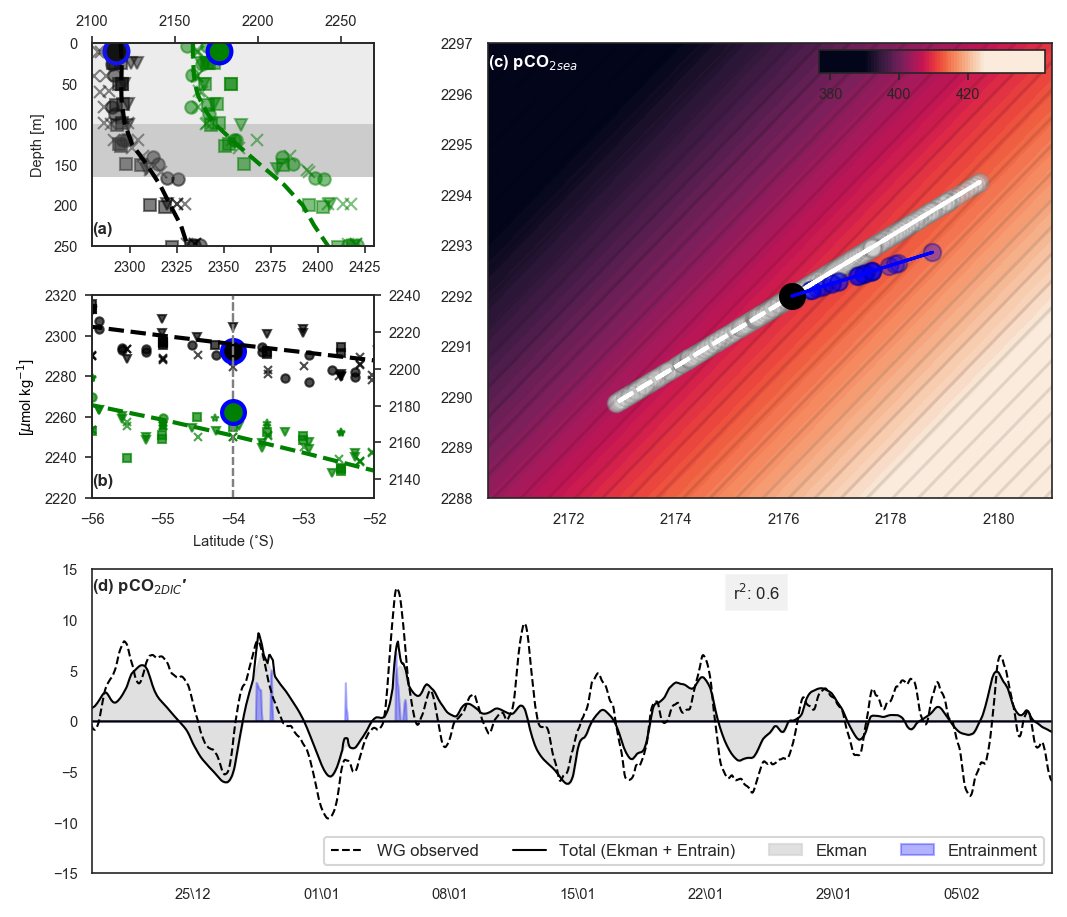

In [30]:

tf=8
fig8 = plt.figure(figsize=(7,6),constrained_layout=True)
gs1 = fig8.add_gridspec(nrows=7, ncols=3,)


# ======  CONCEPTUAL map ====================================================
ax1 = fig8.add_subplot(gs1[0:4, 1:3])

cm=ax1.contourf(WG_dic1,WG_talk1,pCO2_both_WG,100,vmin=390,vmax=425,lw=1)
axins1 = inset_axes(ax1,
                    width="40%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='upper right')
cbar=fig8.colorbar(cm,cax=axins1, orientation="horizontal", ticks=[380,400,420])
ax1.contour(WG_dic1,WG_talk1,pCO2_both_WG,50,colors='k',lw=0.5,alpha=0.1)
ax1.scatter(np.nanmean(WG_dic)+vek_anom_jra_t*np.nanmean(slopes_m_dic1),np.nanmean(WG_talk)+vek_anom_jra_t *np.nanmean(slopes_m_ta1),s=70,color='lightgrey',alpha=0.25,edgecolor='grey') 
ax1.plot(np.nanmean(WG_dic)+vek_anom_jra_t*np.nanmean(slopes_m_dic1),np.nanmean(WG_talk)+vek_anom_jra_t*np.nanmean(slopes_m_ta1),'--',lw=2,color='white',alpha=1)
ax1.plot(np.nanmean(WG_dic),np.nanmean(WG_talk),'ok',markersize=12,lw=3)
ax1.plot(np.nanmean(DIC_ent,1),np.nanmean(ALK_ent,1),color='blue')
ax1.scatter(np.nanmean(DIC_ent,1),np.nanmean(ALK_ent,1),s=70,color='blue',alpha=0.35, edgecolor='darkblue')
ax1.set_title('(c) pCO$_2$$_{sea}$',loc='left',position=(0,0.92),color='white',fontweight='bold',fontsize=tf)
ax1.set_xlim(2170.5,2181)
ax1.set_ylim(2288,2297)


# =========== VERTICAL PROFILES =====================================================
ax2 = fig8.add_subplot(gs1[0:2, 0])
plt.axhspan(100,0,0,1,color='grey',alpha=0.15,lw=0)
plt.axhspan(165,100,0,1,color='grey',alpha=0.4,lw=0)
mark = ['x','o','v','s','*']
i= (glor.talk > 100) & (glor.tco2 > 100) &(glor.depth < 500) & (glor.latitude < -53.5) & (glor.latitude >= -54.5) & (glor.longitude > - .1)& (glor.longitude < .1)
gdap19_wg = glor[i].copy()
ic = (gdap19_wg.cruise == 6) | (gdap19_wg.cruise == 13) | (gdap19_wg.cruise == 14) | (gdap19_wg.cruise == 18) | (gdap19_wg.cruise == 19) | (gdap19_wg.cruise == 385)|(gdap19_wg.cruise == 20)| (gdap19_wg.cruise == 1004)
ax2.plot(ta_b.AT_NNGv2[:,6],depth_b,color='k',ls='--',lw=2)
for i in range(np.size(cruises)):
    ax2.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].talk,gdap19_wg[gdap19_wg.cruise == cruises[i]].depth,marker=mark[i],label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color='k',lw=0,alpha=0.5,zorder=-1)  
ax2.set_ylim(250,0)
ax2.set_xlim(2280,2430)
ax2.scatter(WG.Total_Alkalinity_mumolkg.mean(),10,s=130,color='k',edgecolors='blue',lw=2,label='WG',zorder=1)
ax3 = ax2.twiny() 
ax3.plot(dic_b.TCO2_NNGv2LDEO[:,6],depth_b,color='g',ls='--',lw=2)

for i in range(np.size(cruises)):
    ax3.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].tco2,gdap19_wg[gdap19_wg.cruise == cruises[i]].depth,marker=mark[i],label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color='green',lw=0,alpha=0.5,zorder=-1)
ax3.set_ylim(250,0)
ax3.scatter(WG.Dissolved_Inorganic_Carbon_mumolkg.mean(),10,s=130,color='g',edgecolors='blue',lw=2,label='WG',zorder=1)
ax2.set_title('(a)',loc='left',position = (0,0),fontweight='bold',fontsize=tf)
ax2.set_ylabel('Depth [m]')
ax3.set_xlim(2100,2270)

# ========= HORIZONTAL PROFILES =================================================:
ax2 = fig8.add_subplot(gs1[2:4, 0])
i =  (glor.talk > 0) & (glor.tco2 > 100) & (glor.depth < 50) & (glor.latitude <= -51.5)& (glor.latitude >= -56.5) & (glor.longitude > - .2)& (glor.longitude < .2)
gdap19_wg = glor[i].copy()
ic =  (gdap19_wg.cruise == 6) | (gdap19_wg.cruise == 13) | (gdap19_wg.cruise == 14) | (gdap19_wg.cruise == 18) | (gdap19_wg.cruise == 19) | (gdap19_wg.cruise == 385)|(gdap19_wg.cruise == 20)| (gdap19_wg.cruise == 1004)
for i in range(np.size(cruises)):
    ax2.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude, gdap19_wg[gdap19_wg.cruise == cruises[i]].talk,lw=0,marker=mark[i],markersize=4,label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color='k',alpha=0.7,zorder=-1)
ax2.scatter(-54,WG.Total_Alkalinity_mumolkg.mean(),s=120,color='k',edgecolors='blue',lw=2,label='WG',zorder=1)
ax2.plot(ta_b.lat,np.nanmean(ta_b.AT_NNGv2[0:20,:],0),color='k',ls='--',lw=2)
ax2.set_ylabel('[$\mu$mol kg$^{-1}$]',color='k')
ax2.set_ylim(2220,2320)
ax21 = ax2.twinx()
cruises= [18,19,385,20,1004]
mark = ['x','o','v','s','*']
for i in range(np.size(cruises)):
    ax21.plot(gdap19_wg[gdap19_wg.cruise == cruises[i]].latitude, gdap19_wg[gdap19_wg.cruise == cruises[i]].tco2,lw=0,marker=mark[i],markersize=4,label=str(int(gdap19_wg[gdap19_wg.cruise == cruises[i]].year.values[0])),color='green',alpha=0.7,zorder=-1)
    plt.axvline(-54,color='grey',ls='--',lw=1,zorder=-1)
    ax2.set_xlabel('Latitude (˚S)')
ax21.plot(dic_b.lat,np.nanmean(dic_b.TCO2_NNGv2LDEO[0:20,:],0),color='green',ls='--',lw=2)
ax21.scatter(-54,WG.Dissolved_Inorganic_Carbon_mumolkg.mean(),s=120, color='green',edgecolors='blue',lw=2,zorder=1)
ax21.set_ylim(2130,2240)
ax2.set_xlim(-56,-52)
plt.title('(b)',loc='left',position = (0,0),fontweight='bold',fontsize=tf)



# =========== ESTIMATED VS OBSERVED PCO2 ANOMS =====================================:

ax2 = fig8.add_subplot(gs1[4:7, 0:3])
pCO2_ent1 = pCO2_ent - np.nanmin(pCO2_ent)
ekv['ent_wg_mean_pco2min']  = np.nanmin(pCO2_ent1,1) 
ekv['ent_wg_mean_pco2max']  = np.nanmax(pCO2_ent1,1) 
ekv['ent_wg_mean_pco2mean']  =np.nanmean(pCO2_ent1,1)
total_mean_pco2_min = ekv.ent_wg_mean_pco2min.rolling(7,center=True,min_periods=2).mean() + vek_anom_jra_t*np.nanmin(broulgrads) 
total_mean_pco2_max = ekv.ent_wg_mean_pco2max.rolling(7,center=True,min_periods=2).mean() +  vek_anom_jra_t*np.nanmax(broulgrads) 
total_mean_pco2_mean = ekv.ent_wg_mean_pco2mean.rolling(7,center=True,min_periods=2).mean() +  vek_anom_jra_t*np.nanmean(broulgrads) 

X = pd.to_datetime(WG.Date.values)
Y = WG.PCO2_DIC_anom_muatm.rolling(15,center=True,min_periods=2).mean()
Y1 = ekv.ent_wg_mean_pco2max
Y2 = vek_anom_jra_t*np.nanmean(broulgrads)
x = Y
y = total_mean_pco2_mean

plot(pd.to_datetime(WG.Date.values),Y,label='WG observed',color='k',alpha=1,lw=1,ls='--')
plt.stackplot(X,Y2, baseline="zero",color='lightgrey',alpha=.7,labels=['Ekman'],edgecolor='k',lw=1)
plt.stackplot(X,Y1, baseline="zero",color='blue',alpha=.3,labels=['Entrainment'])
plt.plot(X,y,color='k',ls='-',label='Total (Ekman + Entrain)',lw=1)
y1=y.values[10:-50] # time-series with WG and slocum
x1 =x[10:-50]
slope, intercept, r_value, p_value, std_err = stats.linregress(x1[~numpy.isnan(x1) & ~numpy.isnan(y1)],y1[~numpy.isnan(x1) & ~numpy.isnan(y1)])
rval= np.round(r_value**2,1)
ax2.text(ekv.index.values[850],12,'r$^2$: '+ str(rval),fontsize=tf,bbox=dict(facecolor='lightgrey', alpha=0.3))
ax2.set_ylim(-15,15)
plt.plot(X,Y*0, lw=1,color='k',ls='-')
plt.legend(fontsize=tf,ncol=4,loc=4)
ax2.set_ylim(-15,15)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_major_locator(weeks)
plt.xlim(pd.to_datetime(WG.Date.values)[10],pd.to_datetime(WG.Date.values)[-50]) # WG moved north
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_major_locator(weeks)
plt.title('(d) pCO$_{2DIC}$\u2032',loc='left',position = (0,0.89),fontweight='bold',fontsize=tf)



